<a href="https://colab.research.google.com/github/alexzendersen/metric_learning/blob/main/FACENET_test(5conv_1fc).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import fetch_lfw_people
data = fetch_lfw_people(min_faces_per_person=5, color=True, slice_ = None)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch

In [4]:
data.target_names

array(['Abdullah Gul', 'Adrien Brody', 'Ahmed Chalabi', 'Ai Sugiyama',
       'Al Gore', 'Al Sharpton', 'Alan Greenspan', 'Alastair Campbell',
       'Albert Costa', 'Alejandro Toledo', 'Ali Naimi', 'Allyson Felix',
       'Alvaro Uribe', 'Amelia Vega', 'Amelie Mauresmo', 'Ana Guevara',
       'Ana Palacio', 'Andre Agassi', 'Andy Roddick', 'Angela Bassett',
       'Angela Merkel', 'Angelina Jolie', 'Ann Veneman',
       'Anna Kournikova', 'Antonio Banderas', 'Antonio Palocci',
       'Ari Fleischer', 'Ariel Sharon', 'Arminio Fraga',
       'Arnold Schwarzenegger', 'Arnoldo Aleman', 'Ashanti',
       'Atal Bihari Vajpayee', 'Ben Affleck', 'Benazir Bhutto',
       'Benjamin Netanyahu', 'Bernard Law', 'Bertie Ahern',
       'Bill Clinton', 'Bill Frist', 'Bill Gates', 'Bill Graham',
       'Bill McBride', 'Bill Simon', 'Billy Crystal',
       'Binyamin Ben-Eliezer', 'Bob Graham', 'Bob Hope', 'Bob Stoops',
       'Boris Becker', 'Brad Johnson', 'Britney Spears', 'Bulent Ecevit',
       'Cal

In [5]:
data.target

array([401, 301, 312, ..., 363, 380,  77])

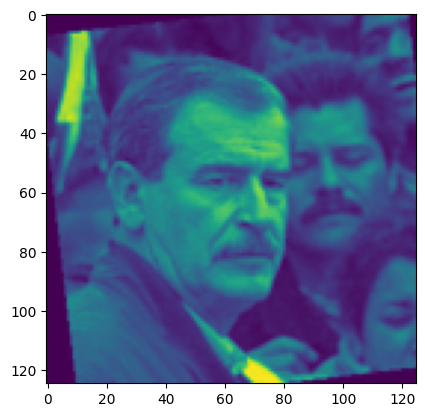

In [6]:
plt.imshow(data.images[0].transpose(2, 0, 1)[1,:,:])

In [7]:
data.images[0].T

array([[[0.        , 0.        , 0.00392157, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.00392157, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.00392157, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.26666668, 0.19215687, 0.11764706, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.01176471, 0.01176471, 0.01176471, ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.21176471, 0.13725491, 0.07058824, ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [8]:
len(data.target_names)

423

In [9]:
np.random.choice(np.where(data.target == 110)[0], 5)

array([1802, 1000, 3893, 2425, 5926])

In [10]:
data.images = data.images.transpose(0, 3, 1, 2)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test_valid, y_train, y_test_valid = train_test_split(data.images, data.target, train_size=0.6, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, train_size = 0.5, random_state = 42)
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_valid = torch.tensor(y_valid)
y_test = torch.tensor(y_test)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class ImageEmbeddingModel(nn.Module):
  def __init__(self):
    super(ImageEmbeddingModel, self).__init__()
    self.cv1 = nn.Conv2d(3, 16, (3, 3), stride = (1, 1))
    self.cv2 = nn.Conv2d(16, 16, (5, 5), stride = (2, 2), padding = (2, 2))
    self.cv3 = nn.Conv2d(16, 16, (3, 3), stride = (1, 1), padding = (1, 1))
    self.cv4 = nn.Conv2d(16, 24, (5, 5), stride = (2, 2), padding = (2, 2))
    self.cv5 = nn.Conv2d(24, 24, (3, 3), stride = (1, 1), padding = (1, 1))
    self.cv6 = nn.Conv2d(24, 24, (3, 3), stride = (1, 1), padding = (1, 1))
    self.fc1 = nn.Linear(1536, 25)
    self.relu = nn.ReLU()

    self.dropout = nn.Dropout2d(p = 0.2)

    self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))


  def forward(self, x):
    x = self.cv1(x)
    x = self.relu(x)
    x = self.cv2(x)
    x = self.pool(x)
    x = self.relu(x)
    x = self.cv3(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.cv4(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.cv5(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.cv6(x)
    x = self.relu(x)
    x = x.flatten(start_dim = 1)
    x = self.fc1(x)

    x = F.normalize(x, dim = 1)

    return x

нужно создать функцию по подбору триплетов. пока что это hard minign (todo: semi-hard)

In [13]:
data.images[0:2:,:,:].shape

(2, 3, 125, 125)

In [14]:
model = ImageEmbeddingModel()
embd = model(torch.tensor(data.images[0:2:,:,:]))
embd.shape

torch.Size([2, 25])

In [15]:
embd = torch.rand(5985, 25)
embd.shape

torch.Size([5985, 25])

In [16]:
def make_triplet(data, labels, margin=1):
  triplets = []
  distance = torch.cdist(data, data)
  inds = torch.randperm(data.shape[0])

  for i in inds:
      ind = i.item()
      anchor_label = labels[ind]
      positive_inds = torch.where(labels == anchor_label)[0].cpu().numpy()
      positive_inds = positive_inds[positive_inds != ind]

      if len(positive_inds) == 0:
          continue

      hardest_positive_index = distance[ind][positive_inds].argmax().item()
      d_pos = distance[ind, hardest_positive_index]

      negative_inds = torch.where(labels != anchor_label)[0]

      mask = (d_pos < distance[ind][negative_inds]) & (distance[ind][negative_inds] < d_pos + margin)
      corr_negs = negative_inds[mask]

      if (corr_negs.shape[0] == 0):
        continue

      negative_index = corr_negs[torch.randint(0, corr_negs.shape[0], (1,)).item()].item()

      triplets.append((data[ind], data[hardest_positive_index], data[negative_index]))

  return triplets

сделаю батчи

In [17]:
def make_bathces(data, labels, class_per_batch = 10):
  unique_labels = labels.unique()
  # shuffle_labels = labels[torch.randperm(labels.shape[0])]

  for i in range(0, unique_labels.shape[0], class_per_batch):
    cur_labels = unique_labels[i:i+class_per_batch]
    inds = torch.nonzero(torch.isin(labels, cur_labels)).squeeze(dim = 1)

    yield data[inds], labels[inds]

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
from sklearn.metrics import accuracy_score

def accuracy(embeddings, labels, threshold, num_samples = 200):
  y_true = []
  y_pred_pos = []
  y_pred_neg = []
  y_pred = []
  distance = torch.cdist(embeddings, embeddings)

  for _ in range(num_samples):
    anchor_ind = torch.randint(0, labels.shape[0], (1,)).item()
    anchor_label = labels[anchor_ind]
    positive_inds = torch.where(labels == anchor_label)[0]
    positive_inds = positive_inds[positive_inds != anchor_ind]
    if (positive_inds.shape[0] == 0):
      continue
    # positive_inds.remove(anchor_ind)
    positive_ind = positive_inds[torch.randint(0, positive_inds.shape[0], (1,)).item()].item()

    negative_inds = torch.where(labels != anchor_label)[0]
    negative_ind = np.random.choice(negative_inds).item()

    dist_pos = distance[anchor_ind, positive_ind].item()
    dist_neg = distance[anchor_ind, negative_ind].item()

    ans = []
    if (dist_pos < threshold):
      ans.append(1)
    else:
      ans.append(0)
    if (dist_neg < threshold):
      ans.append(1)
    else:
      ans.append(0)
    y_pred_pos.append(ans[0])
    y_pred_neg.append(ans[1])

    y_true.extend([1, 0])

  y_pred.extend(y_pred_pos)
  y_pred.extend(y_pred_neg)
  return sum(y_pred_pos) / num_samples, 1 - sum(y_pred_neg) / num_samples, accuracy_score(y_true, y_pred)

43it [00:05,  8.10it/s]


Max accuracy positive = 0.955, max accuracy negative = 1.0


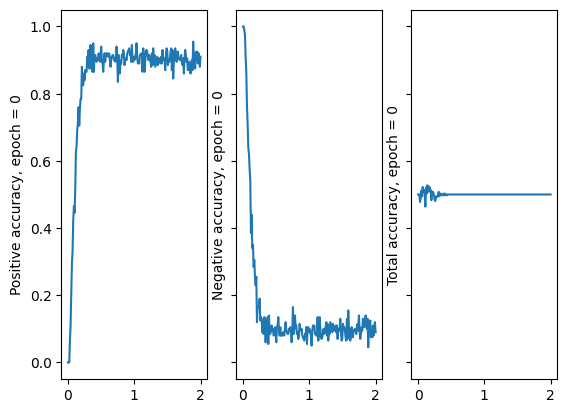

Epoch [1/300], Loss: 0.08676088459434964


43it [00:05,  8.10it/s]


Epoch [2/300], Loss: 0.08967413416221029


43it [00:05,  7.98it/s]


Epoch [3/300], Loss: 0.09295546529548508


43it [00:05,  8.01it/s]


Epoch [4/300], Loss: 0.08395063132047653


43it [00:05,  8.32it/s]


Epoch [5/300], Loss: 0.08632063262519382


43it [00:05,  7.70it/s]


Epoch [6/300], Loss: 0.08798132686033136


43it [00:05,  8.43it/s]


Epoch [7/300], Loss: 0.09159548367772784


43it [00:05,  7.67it/s]


Epoch [8/300], Loss: 0.09067286763872419


43it [00:05,  8.28it/s]


Epoch [9/300], Loss: 0.08741641807414237


43it [00:05,  7.66it/s]


Epoch [10/300], Loss: 0.08091972182903971


43it [00:05,  8.35it/s]


Max accuracy positive = 0.95, max accuracy negative = 1.0


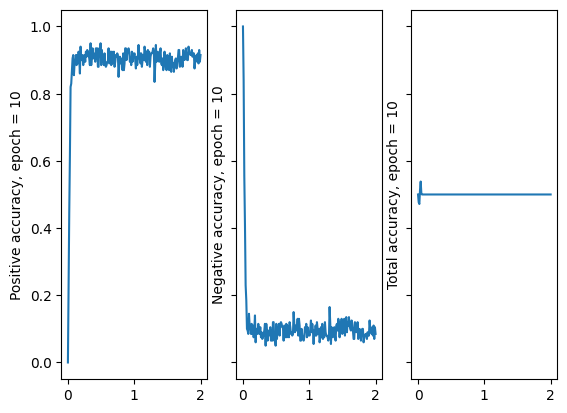

Epoch [11/300], Loss: 0.08349043024437768


43it [00:05,  8.24it/s]


Epoch [12/300], Loss: 0.0844689602298396


43it [00:05,  7.58it/s]


Epoch [13/300], Loss: 0.0869351624555531


43it [00:05,  8.46it/s]


Epoch [14/300], Loss: 0.08487631185423761


43it [00:05,  7.75it/s]


Epoch [15/300], Loss: 0.08739343684698854


43it [00:05,  8.12it/s]


Epoch [16/300], Loss: 0.09617658952871959


43it [00:05,  8.16it/s]


Epoch [17/300], Loss: 0.0880509897002152


43it [00:05,  7.76it/s]


Epoch [18/300], Loss: 0.08711252485712369


43it [00:05,  8.29it/s]


Epoch [19/300], Loss: 0.07999780632200695


43it [00:05,  7.54it/s]


Epoch [20/300], Loss: 0.08920319662207649


43it [00:05,  8.29it/s]


Max accuracy positive = 0.96, max accuracy negative = 1.0


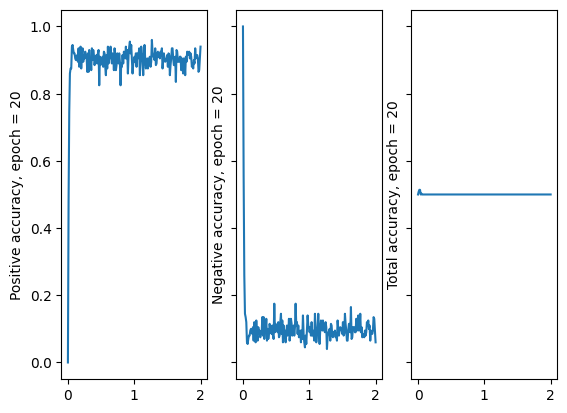

Epoch [21/300], Loss: 0.08323143608868122


43it [00:05,  8.16it/s]


Epoch [22/300], Loss: 0.08644016370886848


43it [00:05,  7.56it/s]


Epoch [23/300], Loss: 0.0853245613120851


43it [00:05,  8.30it/s]


Epoch [24/300], Loss: 0.08732269447119463


43it [00:05,  7.51it/s]


Epoch [25/300], Loss: 0.09137746026473385


43it [00:05,  8.31it/s]


Epoch [26/300], Loss: 0.08318052236877736


43it [00:05,  7.58it/s]


Epoch [27/300], Loss: 0.08250315398687408


43it [00:05,  8.36it/s]


Epoch [28/300], Loss: 0.08823986156355768


43it [00:05,  7.97it/s]


Epoch [29/300], Loss: 0.08891443464727629


43it [00:05,  7.86it/s]


Epoch [30/300], Loss: 0.08738192915916443


43it [00:05,  8.20it/s]


Max accuracy positive = 0.96, max accuracy negative = 1.0


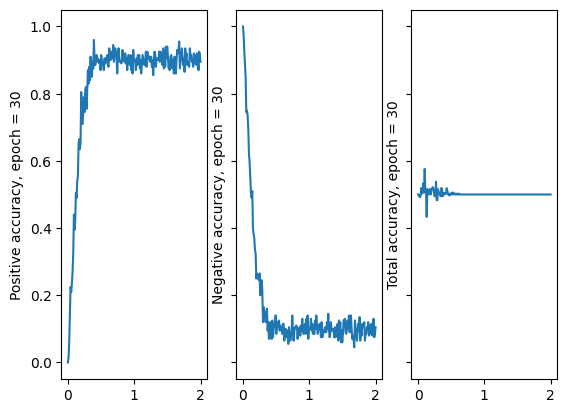

Epoch [31/300], Loss: 0.08707375327746074


43it [00:05,  7.98it/s]


Epoch [32/300], Loss: 0.08267294792901903


43it [00:05,  7.56it/s]


Epoch [33/300], Loss: 0.07920652929516066


43it [00:05,  8.33it/s]


Epoch [34/300], Loss: 0.0827912963217213


43it [00:05,  7.47it/s]


Epoch [35/300], Loss: 0.08110120129727182


43it [00:05,  8.23it/s]


Epoch [36/300], Loss: 0.08249109664133616


43it [00:05,  7.47it/s]


Epoch [37/300], Loss: 0.08717204834378901


43it [00:05,  8.22it/s]


Epoch [38/300], Loss: 0.08496462660176414


43it [00:05,  7.51it/s]


Epoch [39/300], Loss: 0.08135552154410453


43it [00:05,  8.16it/s]


Epoch [40/300], Loss: 0.07826645468317327


43it [00:05,  7.32it/s]


Max accuracy positive = 0.96, max accuracy negative = 1.0


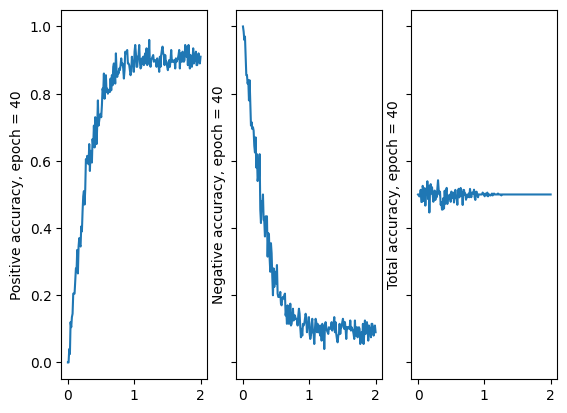

Epoch [41/300], Loss: 0.07870032939882506


43it [00:05,  7.26it/s]


Epoch [42/300], Loss: 0.07653217523225717


43it [00:05,  8.13it/s]


Epoch [43/300], Loss: 0.0801627803593874


43it [00:05,  7.60it/s]


Epoch [44/300], Loss: 0.07919087411747092


43it [00:05,  8.26it/s]


Epoch [45/300], Loss: 0.09090628004854634


43it [00:05,  7.96it/s]


Epoch [46/300], Loss: 0.08858463008488927


43it [00:05,  7.80it/s]


Epoch [47/300], Loss: 0.09833086193317458


43it [00:05,  8.26it/s]


Epoch [48/300], Loss: 0.0908407989357199


43it [00:05,  7.43it/s]


Epoch [49/300], Loss: 0.0939733770986398


43it [00:05,  8.17it/s]


Epoch [50/300], Loss: 0.09044491286788668


43it [00:05,  7.63it/s]


Max accuracy positive = 0.955, max accuracy negative = 1.0


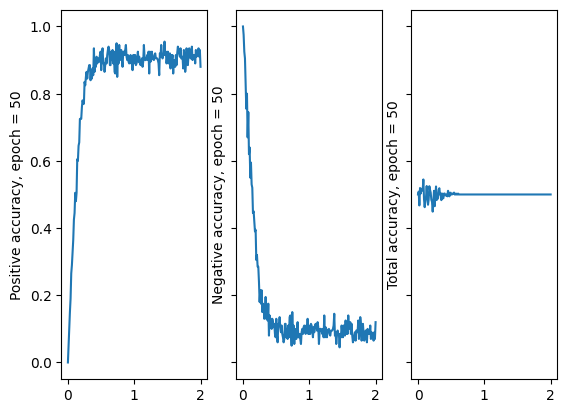

Epoch [51/300], Loss: 0.09170857098485742


43it [00:05,  7.42it/s]


Epoch [52/300], Loss: 0.08579129237859022


43it [00:05,  8.23it/s]


Epoch [53/300], Loss: 0.08930160105228424


43it [00:05,  7.55it/s]


Epoch [54/300], Loss: 0.0852370492759205


43it [00:05,  8.19it/s]


Epoch [55/300], Loss: 0.08222214709080401


43it [00:05,  7.53it/s]


Epoch [56/300], Loss: 0.08069844446366742


43it [00:05,  8.29it/s]


Epoch [57/300], Loss: 0.08728443715898763


43it [00:05,  7.47it/s]


Epoch [58/300], Loss: 0.08118763140269689


43it [00:05,  8.18it/s]


Epoch [59/300], Loss: 0.08216659387662298


43it [00:05,  7.83it/s]


Epoch [60/300], Loss: 0.08098425733901206


43it [00:05,  7.87it/s]


Max accuracy positive = 0.945, max accuracy negative = 1.0


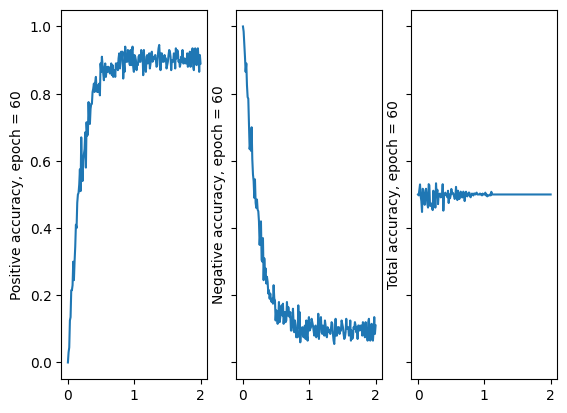

Epoch [61/300], Loss: 0.07589987869418803


43it [00:05,  7.80it/s]


Epoch [62/300], Loss: 0.08380725163789023


43it [00:05,  8.37it/s]


Epoch [63/300], Loss: 0.08490981383337862


43it [00:05,  7.58it/s]


Epoch [64/300], Loss: 0.08560513554229623


43it [00:05,  8.20it/s]


Epoch [65/300], Loss: 0.07854176969045684


43it [00:05,  7.61it/s]


Epoch [66/300], Loss: 0.07726130944987138


43it [00:05,  8.32it/s]


Epoch [67/300], Loss: 0.0792259903890746


43it [00:05,  7.57it/s]


Epoch [68/300], Loss: 0.07817989197515306


43it [00:05,  8.21it/s]


Epoch [69/300], Loss: 0.08044430959437575


43it [00:06,  7.06it/s]


Epoch [70/300], Loss: 0.0820013927739291


43it [00:05,  8.05it/s]


Max accuracy positive = 0.945, max accuracy negative = 1.0


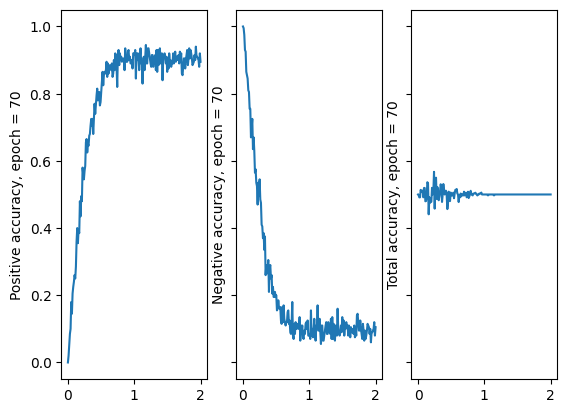

Epoch [71/300], Loss: 0.08795161332402911


43it [00:05,  7.92it/s]


Epoch [72/300], Loss: 0.07829934926260085


43it [00:05,  7.38it/s]


Epoch [73/300], Loss: 0.08099831897942793


43it [00:05,  8.15it/s]


Epoch [74/300], Loss: 0.0850605307412999


43it [00:05,  7.54it/s]


Epoch [75/300], Loss: 0.0859809084130185


43it [00:05,  8.10it/s]


Epoch [76/300], Loss: 0.08494266397541478


43it [00:05,  7.89it/s]


Epoch [77/300], Loss: 0.08766937912220046


43it [00:05,  7.88it/s]


Epoch [78/300], Loss: 0.08187707584528696


43it [00:05,  8.18it/s]


Epoch [79/300], Loss: 0.08658680142391295


43it [00:05,  7.55it/s]


Epoch [80/300], Loss: 0.078726947839771


43it [00:05,  8.18it/s]


Max accuracy positive = 0.955, max accuracy negative = 1.0


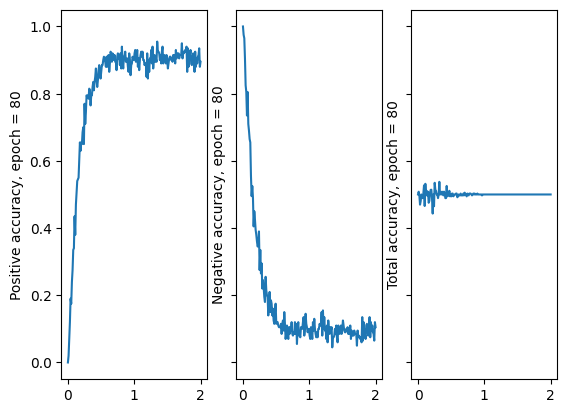

Epoch [81/300], Loss: 0.0779083821745146


43it [00:05,  8.12it/s]


Epoch [82/300], Loss: 0.08128500312921547


43it [00:05,  7.62it/s]


Epoch [83/300], Loss: 0.08111561267148881


43it [00:05,  8.30it/s]


Epoch [84/300], Loss: 0.08191885701602414


43it [00:05,  7.52it/s]


Epoch [85/300], Loss: 0.07670839201836359


43it [00:05,  8.18it/s]


Epoch [86/300], Loss: 0.07580980277132421


43it [00:05,  7.39it/s]


Epoch [87/300], Loss: 0.07654629842866034


43it [00:05,  8.08it/s]


Epoch [88/300], Loss: 0.0776164647901342


43it [00:05,  7.32it/s]


Epoch [89/300], Loss: 0.07696005861674036


43it [00:05,  8.03it/s]


Epoch [90/300], Loss: 0.0839087822075401


43it [00:05,  7.54it/s]


Max accuracy positive = 0.955, max accuracy negative = 1.0


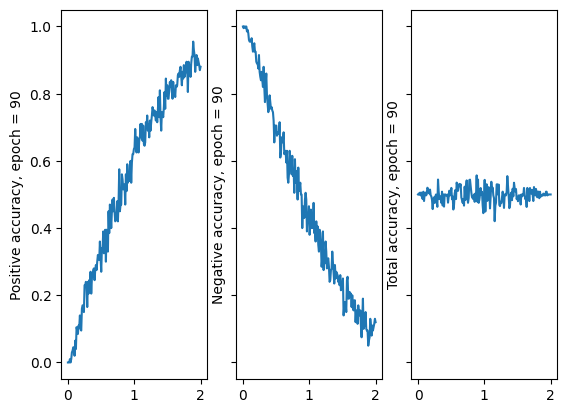

Epoch [91/300], Loss: 0.08164337055668944


43it [00:05,  7.34it/s]


Epoch [92/300], Loss: 0.07997739359381653


43it [00:05,  8.18it/s]


Epoch [93/300], Loss: 0.07794502049329735


43it [00:05,  7.80it/s]


Epoch [94/300], Loss: 0.07681798172138986


43it [00:05,  7.78it/s]


Epoch [95/300], Loss: 0.07658140281481403


43it [00:05,  8.37it/s]


Epoch [96/300], Loss: 0.07499413795414425


43it [00:05,  7.42it/s]


Epoch [97/300], Loss: 0.07636270911565848


43it [00:05,  8.10it/s]


Epoch [98/300], Loss: 0.07763391183245749


43it [00:05,  7.46it/s]


Epoch [99/300], Loss: 0.08187568888422989


43it [00:05,  8.09it/s]


Epoch [100/300], Loss: 0.07946521850923698


43it [00:05,  7.48it/s]


Max accuracy positive = 0.945, max accuracy negative = 1.0


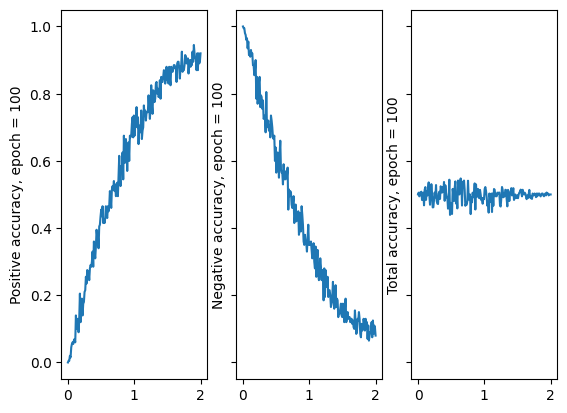

Epoch [101/300], Loss: 0.07408541618358522


43it [00:05,  7.41it/s]


Epoch [102/300], Loss: 0.07577349077023211


43it [00:05,  8.22it/s]


Epoch [103/300], Loss: 0.0740186461203155


43it [00:05,  7.44it/s]


Epoch [104/300], Loss: 0.08012569358661062


43it [00:05,  8.11it/s]


Epoch [105/300], Loss: 0.07558962454398473


43it [00:05,  7.50it/s]


Epoch [106/300], Loss: 0.07852898121234916


43it [00:05,  8.26it/s]


Epoch [107/300], Loss: 0.07660062061179251


43it [00:05,  7.74it/s]


Epoch [108/300], Loss: 0.07540040711561839


43it [00:05,  7.85it/s]


Epoch [109/300], Loss: 0.07712939301771778


43it [00:05,  8.14it/s]


Epoch [110/300], Loss: 0.0777973553077096


43it [00:05,  7.38it/s]


Max accuracy positive = 0.935, max accuracy negative = 1.0


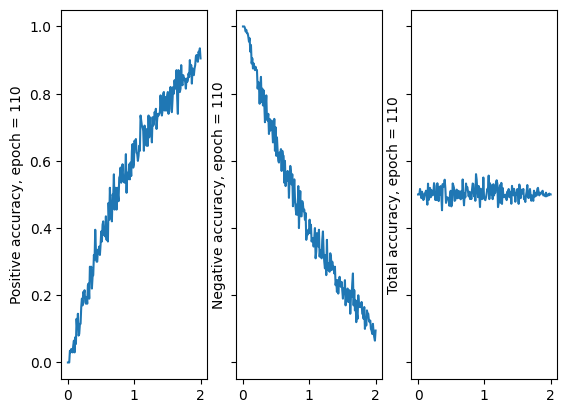

Epoch [111/300], Loss: 0.07878765330782958


43it [00:05,  7.53it/s]


Epoch [112/300], Loss: 0.08273916993112791


43it [00:05,  8.19it/s]


Epoch [113/300], Loss: 0.08167001888865516


43it [00:05,  7.47it/s]


Epoch [114/300], Loss: 0.08142660141346


43it [00:05,  8.20it/s]


Epoch [115/300], Loss: 0.07765635581953186


43it [00:05,  7.48it/s]


Epoch [116/300], Loss: 0.07855234924881231


43it [00:05,  8.18it/s]


Epoch [117/300], Loss: 0.08202782858695302


43it [00:05,  7.48it/s]


Epoch [118/300], Loss: 0.07874254554155327


43it [00:05,  8.16it/s]


Epoch [119/300], Loss: 0.08231755576673008


43it [00:05,  7.51it/s]


Epoch [120/300], Loss: 0.07806563350771155


43it [00:05,  8.13it/s]


Max accuracy positive = 0.94, max accuracy negative = 1.0


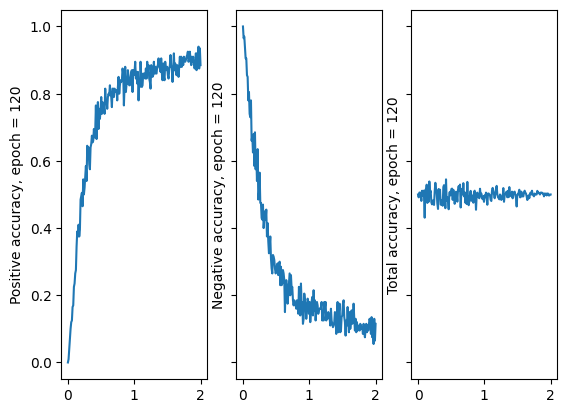

Epoch [121/300], Loss: 0.08125926997689974


43it [00:05,  8.10it/s]


Epoch [122/300], Loss: 0.08217491351422809


43it [00:05,  7.41it/s]


Epoch [123/300], Loss: 0.08324505113774822


43it [00:05,  8.22it/s]


Epoch [124/300], Loss: 0.07859234733595735


43it [00:05,  7.37it/s]


Epoch [125/300], Loss: 0.08271656256346475


43it [00:05,  7.94it/s]


Epoch [126/300], Loss: 0.07884380363282703


43it [00:05,  7.95it/s]


Epoch [127/300], Loss: 0.08039750841756661


43it [00:05,  7.60it/s]


Epoch [128/300], Loss: 0.07915638183199224


43it [00:05,  8.07it/s]


Epoch [129/300], Loss: 0.07441253294902188


43it [00:05,  7.43it/s]


Epoch [130/300], Loss: 0.08187764253289927


43it [00:05,  8.13it/s]


Max accuracy positive = 0.945, max accuracy negative = 1.0


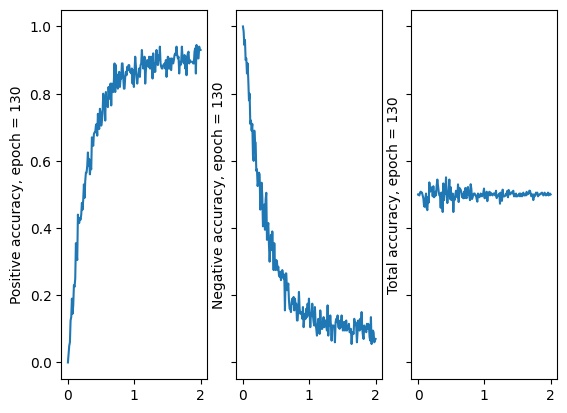

Epoch [131/300], Loss: 0.08179590576106593


43it [00:05,  8.07it/s]


Epoch [132/300], Loss: 0.08065573294602689


43it [00:05,  7.48it/s]


Epoch [133/300], Loss: 0.08142991390611444


43it [00:05,  8.24it/s]


Epoch [134/300], Loss: 0.08126388445851349


43it [00:05,  7.45it/s]


Epoch [135/300], Loss: 0.07687304523729142


43it [00:05,  8.18it/s]


Epoch [136/300], Loss: 0.08005665987730026


43it [00:05,  7.42it/s]


Epoch [137/300], Loss: 0.07742407696232909


43it [00:05,  8.15it/s]


Epoch [138/300], Loss: 0.08296373903396584


43it [00:05,  7.43it/s]


Epoch [139/300], Loss: 0.07965623817983128


43it [00:05,  8.10it/s]


Epoch [140/300], Loss: 0.08217834007172357


43it [00:05,  7.59it/s]


Max accuracy positive = 0.95, max accuracy negative = 1.0


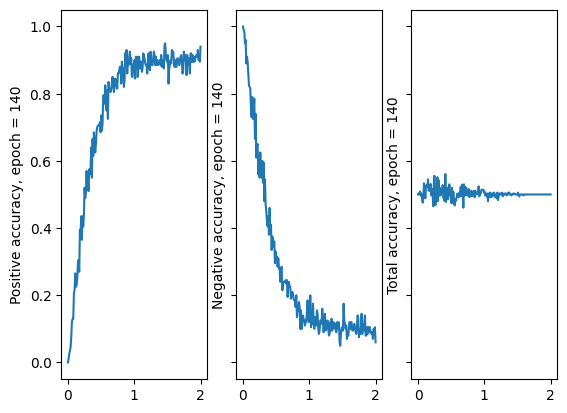

Epoch [141/300], Loss: 0.08055921998761949


43it [00:05,  7.32it/s]


Epoch [142/300], Loss: 0.07807549009365695


43it [00:05,  8.09it/s]


Epoch [143/300], Loss: 0.07675907166586035


43it [00:05,  7.97it/s]


Epoch [144/300], Loss: 0.07829551265708037


43it [00:05,  7.65it/s]


Epoch [145/300], Loss: 0.08688901187408538


43it [00:05,  8.27it/s]


Epoch [146/300], Loss: 0.08804815386732419


43it [00:05,  7.39it/s]


Epoch [147/300], Loss: 0.0779135072869914


43it [00:05,  8.11it/s]


Epoch [148/300], Loss: 0.07620719917828128


43it [00:05,  7.42it/s]


Epoch [149/300], Loss: 0.07492100811075597


43it [00:05,  8.09it/s]


Epoch [150/300], Loss: 0.0790019655334098


43it [00:05,  7.50it/s]


Max accuracy positive = 0.935, max accuracy negative = 1.0


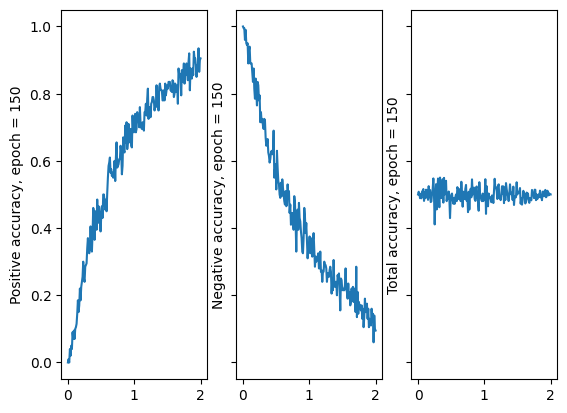

Epoch [151/300], Loss: 0.07829811033748445


43it [00:05,  7.41it/s]


Epoch [152/300], Loss: 0.0774576858218227


43it [00:05,  8.12it/s]


Epoch [153/300], Loss: 0.08314888055125873


43it [00:05,  7.49it/s]


Epoch [154/300], Loss: 0.07761095517448016


43it [00:05,  8.25it/s]


Epoch [155/300], Loss: 0.07986440030591828


43it [00:05,  7.34it/s]


Epoch [156/300], Loss: 0.0784834429976486


43it [00:05,  8.14it/s]


Epoch [157/300], Loss: 0.07516651981998057


43it [00:05,  7.65it/s]


Epoch [158/300], Loss: 0.07412469218529406


43it [00:05,  7.89it/s]


Epoch [159/300], Loss: 0.07863260619342327


43it [00:05,  8.08it/s]


Epoch [160/300], Loss: 0.07752511535017263


43it [00:05,  7.47it/s]


Max accuracy positive = 0.935, max accuracy negative = 1.0


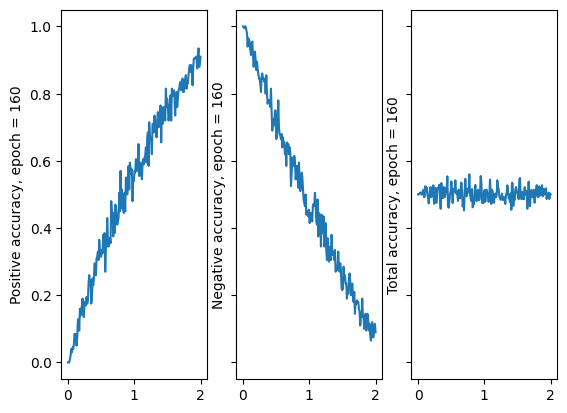

Epoch [161/300], Loss: 0.0798852810902255


43it [00:05,  7.30it/s]


Epoch [162/300], Loss: 0.0767251793295145


43it [00:05,  8.11it/s]


Epoch [163/300], Loss: 0.07873297314203921


43it [00:05,  7.46it/s]


Epoch [164/300], Loss: 0.07709607065078758


43it [00:05,  8.12it/s]


Epoch [165/300], Loss: 0.07792938509512515


43it [00:05,  7.39it/s]


Epoch [166/300], Loss: 0.07610250042662733


43it [00:05,  8.07it/s]


Epoch [167/300], Loss: 0.07755405979142302


43it [00:05,  7.38it/s]


Epoch [168/300], Loss: 0.07537007704377174


43it [00:05,  8.13it/s]


Epoch [169/300], Loss: 0.07788872541416259


43it [00:05,  7.30it/s]


Epoch [170/300], Loss: 0.07383839200649943


43it [00:05,  8.21it/s]


Max accuracy positive = 0.93, max accuracy negative = 1.0


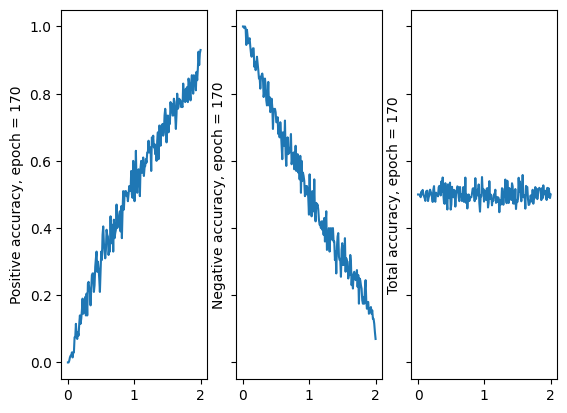

Epoch [171/300], Loss: 0.07508214855832714


43it [00:05,  8.05it/s]


Epoch [172/300], Loss: 0.07636074446851299


43it [00:05,  7.36it/s]


Epoch [173/300], Loss: 0.07493125860180173


43it [00:05,  8.19it/s]


Epoch [174/300], Loss: 0.0724620201757976


43it [00:05,  7.48it/s]


Epoch [175/300], Loss: 0.07446047202462241


43it [00:05,  7.93it/s]


Epoch [176/300], Loss: 0.0775483420916966


43it [00:05,  7.88it/s]


Epoch [177/300], Loss: 0.07724084403543245


43it [00:05,  7.64it/s]


Epoch [178/300], Loss: 0.07728354508678119


43it [00:05,  8.13it/s]


Epoch [179/300], Loss: 0.0799935728843723


43it [00:05,  7.40it/s]


Epoch [180/300], Loss: 0.08149419804768902


43it [00:05,  8.16it/s]


Max accuracy positive = 0.92, max accuracy negative = 1.0


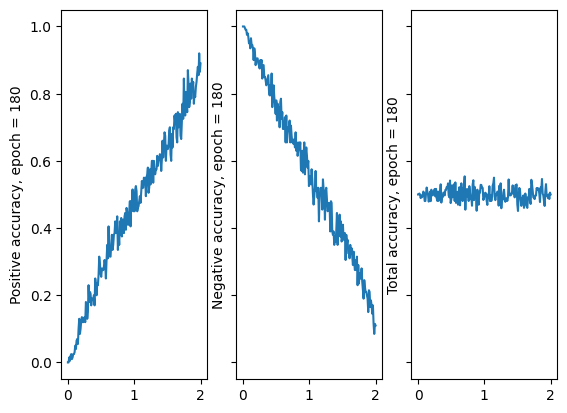

Epoch [181/300], Loss: 0.07980344852521307


43it [00:05,  7.97it/s]


Epoch [182/300], Loss: 0.07675175670356978


43it [00:06,  7.14it/s]


Epoch [183/300], Loss: 0.079334592712777


43it [00:05,  8.18it/s]


Epoch [184/300], Loss: 0.0776128697962988


43it [00:05,  7.32it/s]


Epoch [185/300], Loss: 0.08063243595617157


43it [00:05,  8.10it/s]


Epoch [186/300], Loss: 0.08096866300773053


43it [00:05,  7.32it/s]


Epoch [187/300], Loss: 0.08225780477126439


43it [00:05,  8.13it/s]


Epoch [188/300], Loss: 0.07603601729940801


43it [00:05,  7.31it/s]


Epoch [189/300], Loss: 0.08041283213311717


43it [00:05,  8.08it/s]


Epoch [190/300], Loss: 0.08927514652411143


43it [00:05,  7.35it/s]


Max accuracy positive = 0.895, max accuracy negative = 1.0


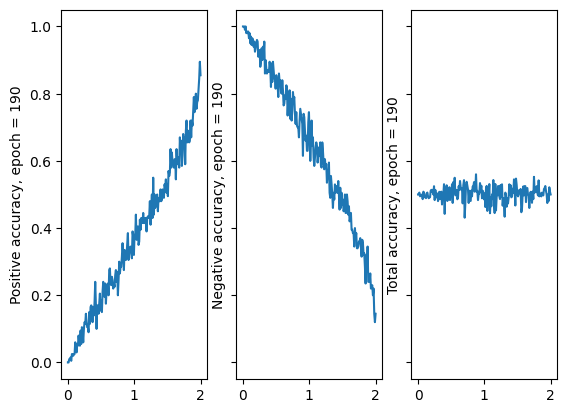

Epoch [191/300], Loss: 0.08544627115840003


43it [00:05,  7.21it/s]


Epoch [192/300], Loss: 0.08421685165237813


43it [00:05,  8.12it/s]


Epoch [193/300], Loss: 0.08470688041831766


43it [00:05,  7.57it/s]


Epoch [194/300], Loss: 0.08064270844416958


43it [00:05,  7.92it/s]


Epoch [195/300], Loss: 0.08256020432426817


43it [00:05,  7.89it/s]


Epoch [196/300], Loss: 0.0828736163675785


43it [00:05,  7.54it/s]


Epoch [197/300], Loss: 0.0793574277666353


43it [00:05,  8.11it/s]


Epoch [198/300], Loss: 0.08117803940106005


43it [00:05,  7.24it/s]


Epoch [199/300], Loss: 0.0778138671247732


43it [00:05,  8.07it/s]


Epoch [200/300], Loss: 0.08170266165619805


43it [00:05,  7.50it/s]


Max accuracy positive = 0.915, max accuracy negative = 1.0


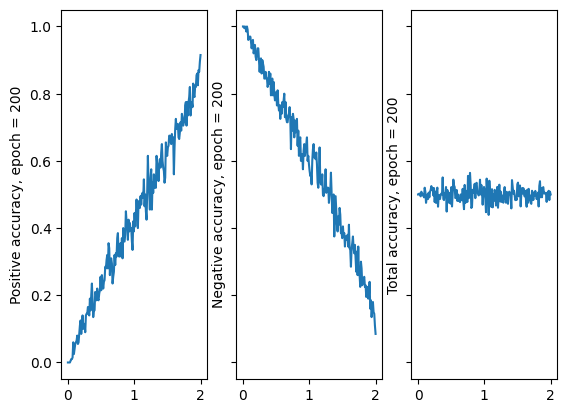

Epoch [201/300], Loss: 0.08106212912216074


43it [00:05,  7.38it/s]


Epoch [202/300], Loss: 0.07785723855098088


43it [00:05,  8.30it/s]


Epoch [203/300], Loss: 0.08066036321577572


43it [00:05,  7.49it/s]


Epoch [204/300], Loss: 0.07705842880975633


43it [00:05,  8.27it/s]


Epoch [205/300], Loss: 0.0780527385040408


43it [00:05,  7.49it/s]


Epoch [206/300], Loss: 0.07773331535004434


43it [00:05,  8.18it/s]


Epoch [207/300], Loss: 0.0775648873476755


43it [00:05,  7.29it/s]


Epoch [208/300], Loss: 0.07669752241954916


43it [00:05,  8.08it/s]


Epoch [209/300], Loss: 0.07924108881325949


43it [00:05,  7.35it/s]


Epoch [210/300], Loss: 0.0800251333663861


43it [00:05,  8.12it/s]


Max accuracy positive = 0.88, max accuracy negative = 1.0


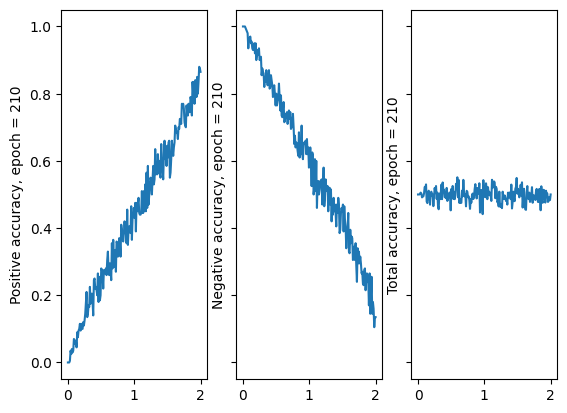

Epoch [211/300], Loss: 0.0807139187873829


43it [00:05,  8.05it/s]


Epoch [212/300], Loss: 0.07907418551899138


43it [00:05,  7.74it/s]


Epoch [213/300], Loss: 0.07713788694569043


43it [00:05,  7.73it/s]


Epoch [214/300], Loss: 0.07988234307794344


43it [00:05,  8.11it/s]


Epoch [215/300], Loss: 0.07695545602057662


43it [00:05,  7.43it/s]


Epoch [216/300], Loss: 0.07777097626101404


43it [00:05,  8.10it/s]


Epoch [217/300], Loss: 0.07805451369356542


43it [00:05,  7.42it/s]


Epoch [218/300], Loss: 0.07792303436214015


43it [00:05,  8.08it/s]


Epoch [219/300], Loss: 0.07658580131828785


43it [00:05,  7.44it/s]


Epoch [220/300], Loss: 0.0774844004994347


43it [00:05,  8.15it/s]


Max accuracy positive = 0.915, max accuracy negative = 1.0


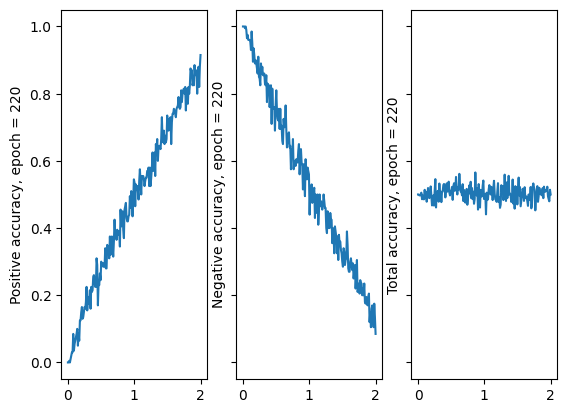

Epoch [221/300], Loss: 0.0764703606033609


43it [00:05,  8.02it/s]


Epoch [222/300], Loss: 0.07773308402725629


43it [00:05,  7.51it/s]


Epoch [223/300], Loss: 0.07986511494077388


43it [00:05,  8.05it/s]


Epoch [224/300], Loss: 0.07505562830538977


43it [00:05,  7.31it/s]


Epoch [225/300], Loss: 0.07753170459043413


43it [00:05,  8.12it/s]


Epoch [226/300], Loss: 0.0759827561144318


43it [00:05,  7.20it/s]


Epoch [227/300], Loss: 0.07731060976428646


43it [00:05,  8.12it/s]


Epoch [228/300], Loss: 0.07828322363396485


43it [00:05,  7.63it/s]


Epoch [229/300], Loss: 0.07787381760066464


43it [00:05,  7.99it/s]


Epoch [230/300], Loss: 0.0768300246979509


43it [00:05,  8.17it/s]


Max accuracy positive = 0.89, max accuracy negative = 1.0


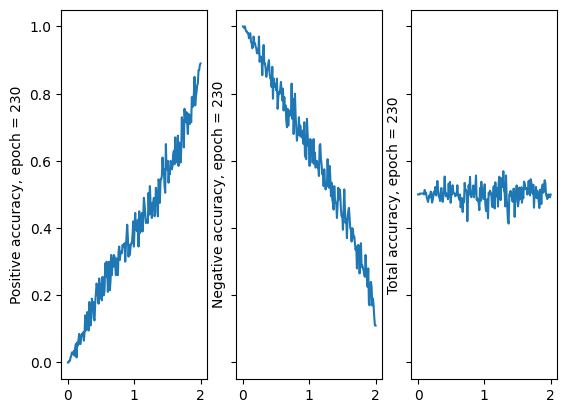

Epoch [231/300], Loss: 0.0774466386508374


43it [00:05,  7.67it/s]


Epoch [232/300], Loss: 0.08064635568076656


43it [00:05,  7.54it/s]


Epoch [233/300], Loss: 0.07730451767288503


43it [00:05,  8.05it/s]


Epoch [234/300], Loss: 0.07726926791171233


43it [00:05,  7.44it/s]


Epoch [235/300], Loss: 0.07481251213522185


43it [00:05,  8.08it/s]


Epoch [236/300], Loss: 0.07401440452252116


43it [00:05,  7.48it/s]


Epoch [237/300], Loss: 0.07746729396638416


43it [00:05,  8.10it/s]


Epoch [238/300], Loss: 0.07967670536821797


43it [00:05,  7.39it/s]


Epoch [239/300], Loss: 0.07594971642607734


43it [00:05,  8.01it/s]


Epoch [240/300], Loss: 0.07768567163674604


43it [00:05,  7.34it/s]


Max accuracy positive = 0.905, max accuracy negative = 1.0


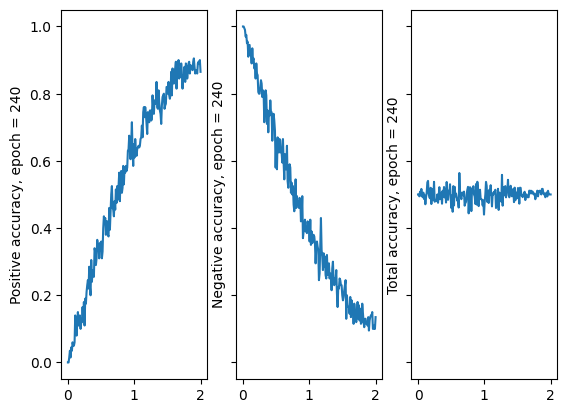

Epoch [241/300], Loss: 0.07272750148106188


43it [00:06,  6.99it/s]


Epoch [242/300], Loss: 0.07233220667001747


43it [00:05,  7.99it/s]


Epoch [243/300], Loss: 0.07868302631236258


43it [00:05,  7.35it/s]


Epoch [244/300], Loss: 0.07686397513108593


43it [00:05,  7.99it/s]


Epoch [245/300], Loss: 0.07489806520087379


43it [00:05,  7.25it/s]


Epoch [246/300], Loss: 0.077316176412361


43it [00:05,  8.10it/s]


Epoch [247/300], Loss: 0.08848348703412783


43it [00:05,  7.51it/s]


Epoch [248/300], Loss: 0.08732414103689648


43it [00:05,  7.74it/s]


Epoch [249/300], Loss: 0.08682006287078063


43it [00:05,  7.81it/s]


Epoch [250/300], Loss: 0.090146765822456


43it [00:05,  7.38it/s]


Max accuracy positive = 0.92, max accuracy negative = 1.0


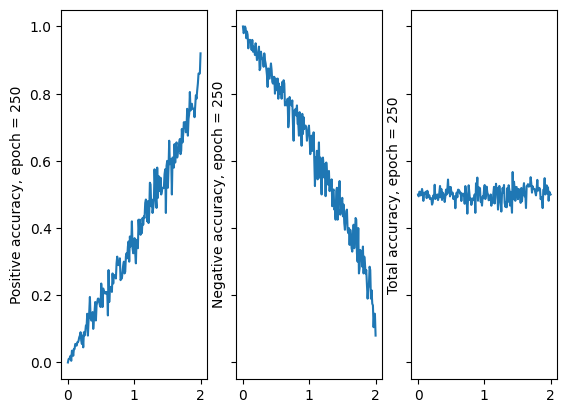

Epoch [251/300], Loss: 0.0861153042919579


43it [00:05,  7.40it/s]


Epoch [252/300], Loss: 0.08360102772712708


43it [00:05,  8.03it/s]


Epoch [253/300], Loss: 0.07881622859055087


43it [00:05,  7.40it/s]


Epoch [254/300], Loss: 0.07764831531260695


43it [00:05,  8.04it/s]


Epoch [255/300], Loss: 0.07947442671727567


43it [00:05,  7.37it/s]


Epoch [256/300], Loss: 0.078171756118536


43it [00:05,  8.08it/s]


Epoch [257/300], Loss: 0.07821772966001715


43it [00:05,  7.40it/s]


Epoch [258/300], Loss: 0.07874906222735133


43it [00:05,  8.09it/s]


Epoch [259/300], Loss: 0.08107623582084973


43it [00:05,  7.30it/s]


Epoch [260/300], Loss: 0.08137063699818793


43it [00:05,  8.09it/s]


Max accuracy positive = 0.935, max accuracy negative = 1.0


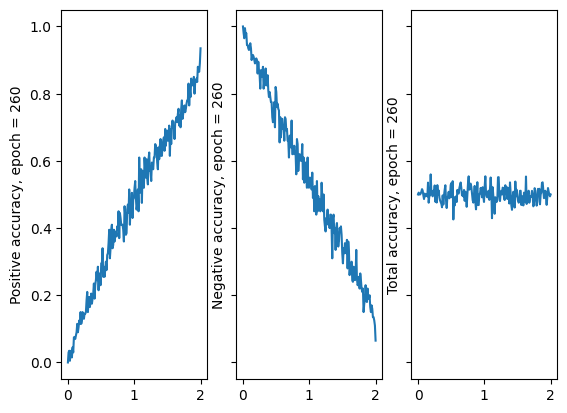

Epoch [261/300], Loss: 0.07701381606360276


43it [00:05,  7.92it/s]


Epoch [262/300], Loss: 0.07843554037667456


43it [00:05,  7.35it/s]


Epoch [263/300], Loss: 0.07905444822141103


43it [00:05,  7.94it/s]


Epoch [264/300], Loss: 0.07799630851617881


43it [00:05,  7.24it/s]


Epoch [265/300], Loss: 0.07719531052169346


43it [00:05,  8.06it/s]


Epoch [266/300], Loss: 0.07972146810165473


43it [00:05,  7.50it/s]


Epoch [267/300], Loss: 0.0775366954150654


43it [00:05,  7.92it/s]


Epoch [268/300], Loss: 0.08046417355182625


43it [00:05,  7.84it/s]


Epoch [269/300], Loss: 0.0769130318824734


43it [00:05,  7.49it/s]


Epoch [270/300], Loss: 0.0793241404351734


43it [00:05,  8.02it/s]


Max accuracy positive = 0.905, max accuracy negative = 1.0


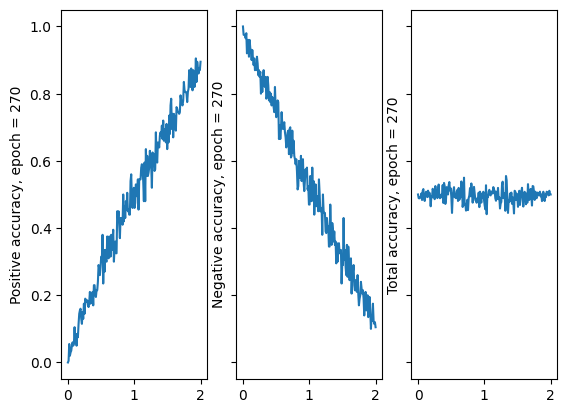

Epoch [271/300], Loss: 0.07845168862314451


43it [00:05,  7.95it/s]


Epoch [272/300], Loss: 0.07600924789550759


43it [00:05,  7.33it/s]


Epoch [273/300], Loss: 0.07676479938839163


43it [00:05,  8.06it/s]


Epoch [274/300], Loss: 0.07569101470566932


43it [00:05,  7.35it/s]


Epoch [275/300], Loss: 0.0780304725326243


43it [00:05,  7.96it/s]


Epoch [276/300], Loss: 0.07748499867461976


43it [00:05,  7.41it/s]


Epoch [277/300], Loss: 0.07602827596877303


43it [00:05,  8.03it/s]


Epoch [278/300], Loss: 0.07838580384850502


43it [00:05,  7.32it/s]


Epoch [279/300], Loss: 0.07964757617030825


43it [00:05,  8.07it/s]


Epoch [280/300], Loss: 0.08156469943267959


43it [00:05,  7.21it/s]


Max accuracy positive = 0.915, max accuracy negative = 1.0


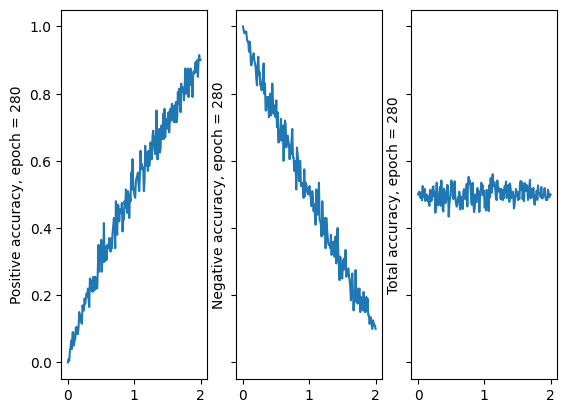

Epoch [281/300], Loss: 0.08175660377102238


43it [00:06,  7.09it/s]


Epoch [282/300], Loss: 0.07914616132066363


43it [00:05,  8.05it/s]


Epoch [283/300], Loss: 0.0808371247812396


43it [00:05,  7.35it/s]


Epoch [284/300], Loss: 0.08213645432676588


43it [00:05,  7.96it/s]


Epoch [285/300], Loss: 0.08077784201928548


43it [00:05,  7.49it/s]


Epoch [286/300], Loss: 0.07735010999299231


43it [00:05,  7.92it/s]


Epoch [287/300], Loss: 0.08233408771810077


43it [00:05,  7.84it/s]


Epoch [288/300], Loss: 0.07734672059970242


43it [00:05,  7.46it/s]


Epoch [289/300], Loss: 0.08040513302243892


43it [00:05,  8.01it/s]


Epoch [290/300], Loss: 0.08239705949312165


43it [00:05,  7.27it/s]


Max accuracy positive = 0.915, max accuracy negative = 1.0


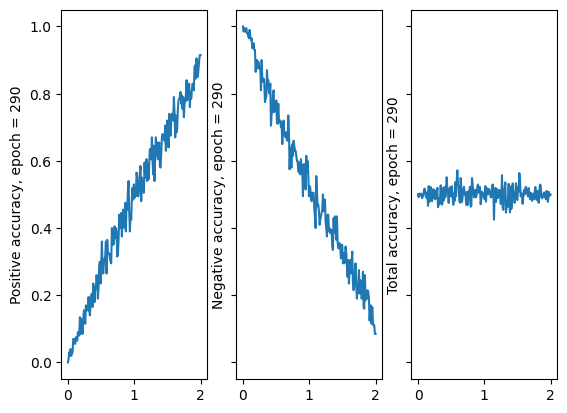

Epoch [291/300], Loss: 0.07866943059932618


43it [00:06,  7.15it/s]


Epoch [292/300], Loss: 0.0804868849615256


43it [00:05,  8.07it/s]


Epoch [293/300], Loss: 0.07566337881698496


43it [00:05,  7.43it/s]


Epoch [294/300], Loss: 0.07783844694495201


43it [00:05,  8.07it/s]


Epoch [295/300], Loss: 0.0758364446283806


43it [00:05,  7.34it/s]


Epoch [296/300], Loss: 0.07637399878530275


43it [00:05,  8.01it/s]


Epoch [297/300], Loss: 0.07909899338015489


43it [00:05,  7.33it/s]


Epoch [298/300], Loss: 0.07635699177072161


43it [00:05,  8.02it/s]


Epoch [299/300], Loss: 0.07239740120158308


43it [00:05,  7.18it/s]

Epoch [300/300], Loss: 0.069039890453929


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

triplet_criterion = nn.TripletMarginLoss(margin = 0.2).to(device)
model = ImageEmbeddingModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-4)

freq = 10

num_epochs = 300

epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    num_batches = 0

    for batch in tqdm(make_bathces(X_train, y_train)):
        images, labels = batch[0].to(device), batch[1].to(device)
        embedding = model(images)
        triplets = make_triplet(embedding, labels, margin = 0.3)
        losses = []
        for triplet in triplets:
            loss = triplet_criterion(*triplet)
            losses.append(loss)
        if len(triplets) == 0:
          continue
        total_loss = torch.mean(torch.stack(losses))
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
        num_batches += 1

    if (epoch % freq == 0):
      thresholds = np.linspace(0, 2, 200)
      model.eval()
      embeds = model(X_valid.to(device))
      accs_pos = []
      accs_neg = []
      accs_tot = []
      for threshold in thresholds:
        acc_pos, acc_neg, acc_total = accuracy(embeds.cpu(), y_valid, threshold)
        accs_pos.append(acc_pos)
        accs_neg.append(acc_neg)
        accs_tot.append(acc_total)
      print(f"Max accuracy positive = {max(accs_pos)}, max accuracy negative = {max(accs_neg)}")
      fig, axis = plt.subplots(nrows = 1, ncols = 3, sharey = True)
      axis[0].set_ylabel(f"Positive accuracy, epoch = {epoch}")
      axis[1].set_ylabel(f"Negative accuracy, epoch = {epoch}")
      axis[2].set_ylabel(f"Total accuracy, epoch = {epoch}")
      axis[0].plot(thresholds, accs_pos)
      axis[1].plot(thresholds, accs_neg)
      axis[2].plot(thresholds, accs_tot)

      plt.show()

    avg_epoch_loss = epoch_loss / num_batches
    epoch_losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss}")






In [ ]:
X_test[0].shape

(3, 125, 125)

In [20]:
model = ImageEmbeddingModel()
model.load_state_dict(torch.load('face_embedding_model.pth', map_location=device))
model.to(device)

<ipython-input-20-3e5c9b349dac>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('face_embedding_model.pth', map_location=device))


ImageEmbeddingModel(
  (cv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (cv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (cv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cv4): Conv2d(16, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (cv5): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cv6): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1536, out_features=25, bias=True)
  (relu): ReLU()
  (dropout): Dropout2d(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)

In [21]:
model.eval()

ImageEmbeddingModel(
  (cv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (cv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (cv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cv4): Conv2d(16, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (cv5): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cv6): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1536, out_features=25, bias=True)
  (relu): ReLU()
  (dropout): Dropout2d(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
X_test = torch.tensor(X_test)
X_test.shape

<ipython-input-37-dbfa91610567>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test)


torch.Size([898, 3, 125, 125])

In [24]:
thresholds = np.linspace(0, 2, 200)

embeds = model(X_test.to(device))
labels = y_test

In [25]:
labels.shape

torch.Size([1197])

In [26]:
embeds.shape

torch.Size([1197, 25])

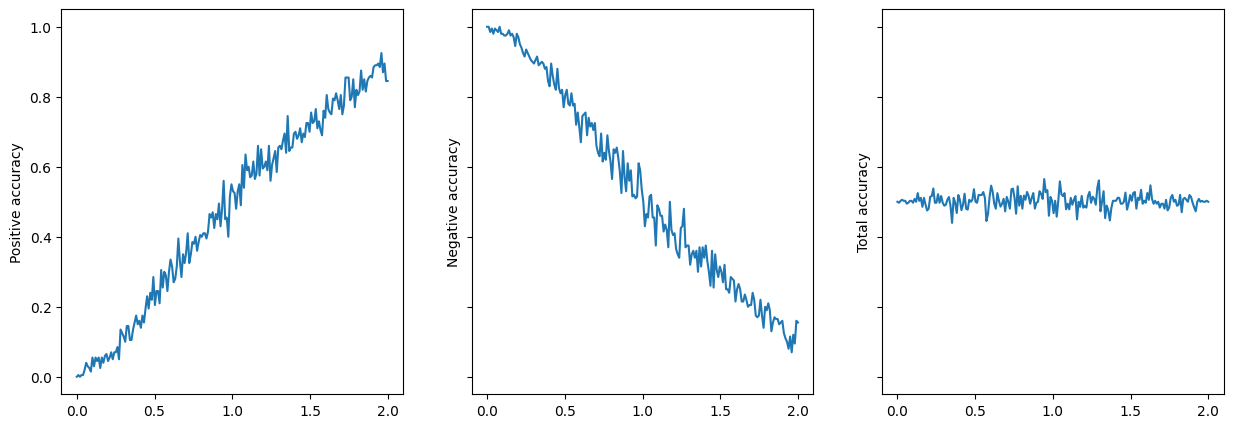

In [32]:
accs_pos = []
accs_neg = []
accs_tot = []


for t in thresholds:
  a_pos, a_neg, a_tot = accuracy(embeds, labels, t)
  accs_pos.append(a_pos)
  accs_neg.append(a_neg)
  accs_tot.append(a_tot)

fig, axis = plt.subplots(nrows = 1, ncols = 3, sharey = True, figsize = (15, 5))
axis[0].set_ylabel(f"Positive accuracy")
axis[1].set_ylabel(f"Negative accuracy")
axis[2].set_ylabel(f"Total accuracy")
axis[0].plot(thresholds, accs_pos)
axis[1].plot(thresholds, accs_neg)
axis[2].plot(thresholds, accs_tot)

plt.show()

In [29]:
# Путь для сохранения весов
model_path = "face_embedding_model.pth"

# Сохранение весов
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")

Model weights saved to face_embedding_model.pth
